In [1]:
import os
from itertools import product
from copy import copy
from collections import defaultdict
import numpy as np
from numpy import heaviside, exp
import pandas as pd
from scipy.interpolate import interp1d, interp2d, splrep, splev
from scipy.optimize import minimize, brentq
from scipy.stats import linregress

In [2]:
import seaborn as sns
sns.set(context='paper', style='whitegrid', font='serif', rc={
    'axes.formatter.useoffset': False,
    'font.serif': 'STIXGeneral',
    'mathtext.fontset': 'stix'
})
%matplotlib inline

In [3]:
data = {}
with pd.HDFStore('../data/all-data.h5') as store:
    for key in 'scf mbd dftd3_bj vv10 flakes bz_tests'.split():
        data[key] = store[key]

In [4]:
# filter out data points where distance = 2 and reference energy is nonnegative
mask = (data['scf'].index.get_level_values('dist') == 2.) & (data['scf']['ref'] >= 0)
data['scf'].drop(data['scf'].loc[mask].index, inplace=True)

In [5]:
# set base energy (used to get relative energy) to abs(ref)
# and flatten the dip around ene_ref = 0
def mod_ref1(df):
    if len(df) == 1:
        return df
    ibase = df['ref'].idxmin()
    base = df.loc[ibase, 'base']
    dist = ibase[2]
    mask = (df.index.get_level_values('dist') < dist) & (df['base'] < base)
    df.loc[mask, 'base'] = base
    return df

data['scf'] = data['scf'] \
    .assign(base=lambda x: abs(x['ref'])) \
    .groupby(level='name system xc'.split()) \
    .apply(mod_ref1)

In [6]:
def savefig(name, **kwargs):
    sns.plt.savefig(
        os.path.expanduser(f'../media/{name}.pdf'),
        transparent=True,
        **{'bbox_inches': 'tight', **kwargs}
    )
    
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'median': df['reldelta'].median(),
        'MAE': abs(df['delta']).mean(),
    })

def normalize_names(col):
    names = {
        'scan': 'SCAN',
        'scan0': 'SCAN0',
        'scan(a)': "SCAN*\n($c_{2\\mathrm{x}}=0.3$)",
        'scan(b)': "SCAN*\n($d_\\mathrm{x}=2$)",
        'b3lyp': 'B3LYP',
        'lda': 'LDA',
        'm06': 'M06',
        'pbe': 'PBE',
        'pbe0': 'PBE0',
        'tpss': 'TPSS',
        'pbe+mbd': 'PBE+MBD',
    }
    if col.name.lower() == 'xc':
        return [names.get(k, k) for k in col]
    return col
    
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    sns.plt.plot(beta, mean(beta), '--', **kwargs)
    sns.plt.plot(beta, std(beta), '-', **kwargs)
    sns.plt.plot(beta, mare(beta), ':', **kwargs)
    sns.plt.axhline(color='black')

def zero_dist(df):
    df = df.copy()
    df['dist'] = 1.
    df['name'] = df['name'] + '_T'
    return df

def merge_scfs_vdws(vdw, baseidx, scfidxs, vdwidxs, params):
    data_vdw = data[vdw] if type(vdw) is str else vdw
    df = pd.merge(
        pd.concat(data['scf'].loc[baseidx + idx, :] for idx in scfidxs).reset_index(),
        pd.concat(data_vdw.loc[baseidx + idx, :] for idx in vdwidxs).reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    df.set_index('name xc system dist'.split() + params, inplace=True)
    df['ene'] = df['ene_scf']+df['ene_vdw']
    df['delta'] = df['ene']-df['ref']
    df['reldelta'] = df['delta']/df['base']
    return df

def merge_scf_vdw(vdw, baseidx, scfidx, vdwidx, params):
    return merge_scfs_vdws(vdw, baseidx, [scfidx], [vdwidx], params)

## Figures

In [7]:
stats = pd.concat([merge_scf_vdw(
    'mbd', ('S66x8', slice(None), 1.), (xc,), (6, beta), 'a beta'.split()
).reset_index() for xc, beta in [
    ('lda', 10.), ('lda', 1.4), ('pbe', .83), ('pbe0', .83),
    ('b3lyp', .67), ('scan', 1.1), ('scan', 1.4), ('m06', 1.2),
    ('scan(a)', 1.1), ('scan(b)', 0.9), ('scan(c)', 1.1)
]]).groupby(['xc', 'beta']).apply(get_stat)
stats

MAE      MARE       STD      mean    median
xc      beta                                                   
b3lyp   0.67   0.679750  0.150810  0.199402  0.084225  0.043510
lda     1.40   2.101303  0.399624  0.139764 -0.399624 -0.414421
        10.00  1.797654  0.317197  0.157515 -0.313818 -0.352190
m06     1.20   0.299705  0.084288  0.132667 -0.012718  0.011732
pbe     0.83   0.404164  0.083790  0.101529 -0.028030 -0.034843
pbe0    0.83   0.423615  0.081403  0.086702 -0.042825 -0.061067
scan    1.10   0.740526  0.140300  0.055918 -0.139345 -0.137843
        1.40   0.569702  0.116505  0.136157  0.037813  0.015608
scan(a) 1.10   0.208141  0.044993  0.058960 -0.016382 -0.015751
scan(b) 0.90   0.207589  0.043648  0.059626  0.003911  0.002880
scan(c) 1.10   0.389052  0.069311  0.061867 -0.051360 -0.061469

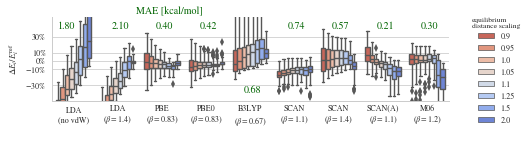

In [8]:
def get_name(row):
    name = row['xc'].upper()
    name += '\n({})'.format(f'$\\beta={row["beta"]}$' if row['beta'] != 10. else 'no vdW')
    return name

keys = [
    ('lda', 10.), ('lda', 1.4), ('pbe', .83), ('pbe0', .83),
    ('b3lyp', .67), ('scan', 1.1), ('scan', 1.4), ('scan(a)', 1.1),
    ('m06', 1.2),
]

with sns.color_palette(list(reversed(sns.color_palette('coolwarm', 8)))):
    g = sns.factorplot(
        data=pd.concat([merge_scf_vdw(
            'mbd', ('S66x8', slice(None), slice(None)), (xc,), (6, beta), 'a beta'.split()
        ).reset_index() for xc, beta in keys]).assign(
            xc_beta=lambda x: x.apply(get_name, axis=1)
        )
        .rename(columns={'dist': 'equilibrium\ndistance scaling'}),
        kind='box',
        x='xc_beta',
        y='reldelta',
        hue='equilibrium\ndistance scaling',
        whis=2.5,
        aspect=3.2,
        size=2.,
        margin_titles=True
    )
sns.plt.ylim(-.5, .55)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E_i/E_i^\mathrm{ref}$')
g.set(yticks=[-.3, -.1, 0, .1, .3])
g.set_yticklabels(['$-30\%$', '$-10\%$', '0%', '10%', '30%'])
for i, key in enumerate(keys):
    x, y = i-0.15, .4
    if key == ('lda', 10.):
        x -= .2
    if key == ('b3lyp', .67):
        y = -.4
    g.ax.text(x, y, '{:.2f}'.format(stats.loc[key, 'MAE']), color='darkgreen')
g.ax.text(1.4, .58, 'MAE [kcal/mol]', color='darkgreen')
savefig('s66-dists')

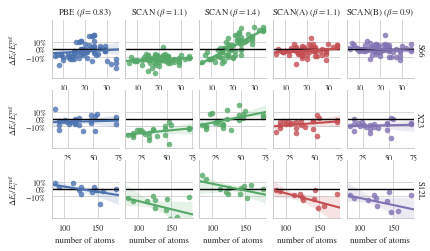

In [9]:
def regplot(*args, **kwargs):
    sns.plt.axhline(color='black')
    # sns.kdeplot(*args, **kwargs, n_levels=5)
    sns.regplot(*args, **kwargs)
    
def get_name(row):
    name = row['xc'].upper()
    name += ' ({})'.format(f'$\\beta={row["beta"]}$' if row['beta'] != 10. else 'no vdW')
    return name

g = sns.FacetGrid(
    data=pd.concat([merge_scf_vdw(
        'mbd', ('S66x8 S12L X23'.split(), slice(None), 1.), (xc,), (6, beta), 'a beta'.split()
    ).reset_index() for xc, beta in [
        ('pbe', .83), ('scan', 1.1), ('scan', 1.4), ('scan(a)', 1.1), ('scan(b)', 0.9)
    ]]).assign(XC=lambda x: x.apply(get_name, axis=1))
    .rename(columns={'natoms': 'number of atoms', 'name': 'dataset'})
    .replace('S66x8', 'S66'),
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    hue='xc',
    size=1.2,
    margin_titles=True,
    sharex=False,
).map(regplot, 'number of atoms', 'reldelta')
sns.plt.ylim(-.4, .4)
g.set_ylabels(r'$\Delta E_i/E_i^\mathrm{ref}$')
yticks = [-.1, 0, .1]
g.set(yticks=yticks)
# g.set_xticklabels(xticks)
g.set_yticklabels(['$-10\%$', '0%', '10%'])
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.fig.subplots_adjust(wspace=.1, hspace=.2)
savefig('size-dependence')

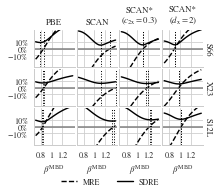

In [10]:
def plot_stat(**kwargs):
    global line1, line2
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    line1, = sns.plt.plot(beta, mean(beta), '--', color='black')
    line2, = sns.plt.plot(beta, std(beta), '-', color='black')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    sns.plt.axhline(color='gray', lw=1.5)
    sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)
    
g = sns.FacetGrid(
    data=merge_scf_vdw(
        'mbd',
        ('S66x8 S12L X23'.split(), slice(None), 1.),
        ('pbe scan scan(a) scan(b)'.split(),),
        (6, slice(.7, 1.5)),
        'a beta'.split()
    ).reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    size=.9,
    aspect=.85,
    margin_titles=True
).map_dataframe(plot_stat)
g.fig.legend(
    (line1, line2), ('MRE', 'SDRE'),
    loc='lower center', bbox_to_anchor=(.5, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.23)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$\beta^\mathrm{MBD}$')
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
xticks = [.8, 1, 1.2]
yticks = [-.1, 0, .1]
g.set(xticks=xticks, yticks=yticks)
g.set_xticklabels(xticks)
g.set_yticklabels(['$-10$%', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('mbd-param-fitting')

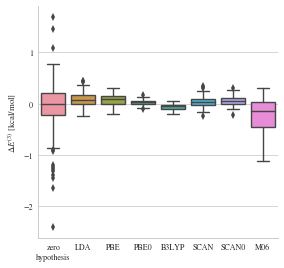

In [11]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'zero\nhypothesis'
    df['delta'] = df['ref']
    return df

g = sns.factorplot(
    data=pd.concat([
        data['scf'].loc[
            '3B-69',
            slice(None),
            slice(None),
            'pbe pbe0 scan scan0 lda m06 b3lyp'.split(),
        ].reset_index().assign(delta=lambda df: df['ene']-df['ref']),
        data['scf'].loc[
            '3B-69', slice(None), slice(None), 'pbe'
        ].reset_index().pipe(replace_ref)
    ])
    .apply(normalize_names),
    kind='box',
    x='xc',
    y='delta',
    order=['zero\nhypothesis'] + 'LDA PBE PBE0 B3LYP SCAN SCAN0 M06'.split(),
    size=4,
)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E^{(3)}$ [kcal/mol]')
savefig('3-body')

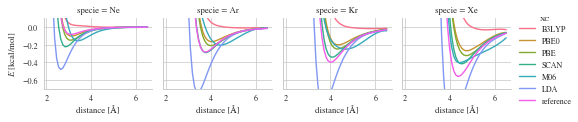

In [12]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'reference'
    df['ene'] = df['ref']
    return df

def plot_curve(x, y, **kwargs):
    yinp  = interp1d(x, y, kind='cubic')
    xfine = np.linspace(x.min(), x.max())
    sns.plt.plot(xfine, yinp(xfine), **kwargs)
    
g = sns.FacetGrid(
    data=pd.concat([
        merge_scf_vdw(
            'mbd',
            ('rare-gas', slice(None), slice(None, 7.)),
            ('pbe pbe0 scan m06 lda b3lyp'.split(),),
            (6, 1.),
            'a beta'.split()
        ).reset_index(),
        data['scf'].loc[(
            'rare-gas', slice(None), slice(None, 7.), 'pbe'
        ), :].reset_index().pipe(replace_ref)
    ])
    .apply(normalize_names)
    .rename(columns={'xc': 'XC', 'system': 'specie'}), 
    col='specie',
    col_order='Ne Ar Kr Xe'.split(),
    hue='XC',
    size=1.8,
    hue_order='B3LYP PBE0 PBE SCAN M06 LDA reference'.split(),
).map(plot_curve, 'dist', 'ene').add_legend()
sns.plt.ylim(-.7, .1)
g.set_xlabels('distance [Å]')
g.set_ylabels(r'$E$ [kcal/mol]')
savefig('mbd-rare-gas')

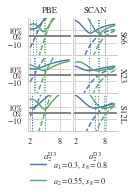

In [13]:
lines = {}

def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    color = kwargs.pop('color')
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='gray', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scfs_vdws(
        'dftd3_bj',
        ('S66x8 X23 S12L'.split(), slice(None), 1.),
        [('pbe scan'.split(),)],
        [(.30000000000000004, slice(2., 11.), .8), (.55, slice(2., 11.), 0.)],
        'a1 a2 s8'.split()
    ).reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    hue='s8',
    row='dataset',
    col='XC',
    size=.9,
    row_order='S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
lines = list(lines.values())
lines = [copy(lines[i]) for i in [0, 1, 1, 3]]
lines[0].set_color('black')
lines[1].set_color('black')
lgnd = g.fig.legend(
    lines[2:],
    ('$a_1=0.3$, $s_8=0.8$', '$a_2=0.55$, $s_8=0$'),
    loc='lower center', bbox_to_anchor=(.53, 0)
)
g.fig.subplots_adjust(bottom=0.3)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$a_2^\mathrm{D3}$')
xticks = [2, 8]
yticks = [-.1, 0, .1]
g.set(xticks=xticks, yticks=yticks)
g.set_yticklabels(['$-10%$', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('d3-param-fitting')

In [14]:
def interp_vv10(bs):
    def func(r):
        f = interp1d(r.index, r)
        return pd.Series({b: ene for b, ene in zip(bs, f(bs))})
    return data['vv10']['ene'] \
        .unstack().apply(lambda r: r['nlc'] if r.name[0] == 'S12L' else r['vdw']-r['base'], axis=1) \
        .unstack().apply(func, axis=1).rename_axis('b', axis=1).stack().to_frame('ene')

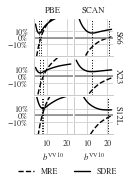

In [15]:
lines = {}

def plot_stat(**kwargs):
    param = 'b'
    df = kwargs.pop('data').groupby(param).apply(get_stat).reset_index()
    color = 'black' # kwargs.pop('color')
    mean = interp1d(df[param], df['mean'], kind='cubic')
    std = interp1d(df[param], df['STD'], kind='cubic')
    a2 = np.linspace(df[param].min(), df[param].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='gray', lw=1.5)
    bounds = [(df[param].min()+1e-6, df[param].max()-1e-6)]
    opt_std = minimize(std, 10., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scf_vdw(
        interp_vv10(np.linspace(4.5, 22., 10)),
        ('S66x8 X23 S12L'.split(), slice(None), 1.),
        ('pbe scan'.split(),),
        (),
        'b'.split()
    ).reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    row='dataset',
    col='XC',
    size=.85,
    row_order='S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
lgnd = g.fig.legend(
    lines.values(),
    ('MRE', 'SDRE'),
    loc='lower center', bbox_to_anchor=(.55, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.25)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$b^\mathrm{VV10}$')
yticks = [-.1, 0, .1]
g.set(yticks=yticks)
g.set_yticklabels(['$-10\%$', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('vv10-param-fitting')

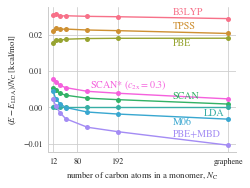

In [16]:
def get_int_ene(x):
    if len(x) != 3:
        return
    x = x.unstack()
    if len(x.shape) == 2:
        x = x.iloc[0]
    df = pd.DataFrame({
        'ene': [
            x['ene', 'dimers-AA']-2*x['ene', 'monomers'],
            x['ene', 'dimers-AB']-2*x['ene', 'monomers']
        ],
        'nelec': x['nelec', 'dimers-AA'],
        'ncarbons': x['ncarbons', 'dimers-AA'],
        'gap': [x['gap', 'dimers-AA'], x['gap', 'dimers-AB']]
    }, index=pd.Index(['AA', 'AB'], name='stacking'))
    return df

def subtract_lda(x):
    lda = x.xs('lda', level='xc')['ene'].iloc[0]
    return x.assign(rene=lambda y: y['ene']-lda)

lines = {}

def plot(**kwargs):
    df = kwargs.pop('data')
    xc = df['XC functional'].iloc[0]
    x = df['scale']
    y = df['renepc']
    sns.plt.plot(x, y, 'o', markersize=5, **kwargs)
    lines[xc], = sns.plt.plot(x, y, '-', **kwargs)
    
keys = 'B3LYP TPSS PBE SCAN LDA M06 PBE+MBD'.split() + ['SCAN*\n($c_{2\\mathrm{x}}=0.3$)']
graph_data = (
    data['flakes'].groupby('name basis xc'.split()).apply(get_int_ene)
        .xs('tight', level='basis')
        .xs('AB', level='stacking')
        .groupby(level='name').apply(subtract_lda)
        .assign(renepc=lambda x: x['rene']/x['ncarbons'])
        .assign(enepc=lambda x: x['ene']/x['ncarbons'])
        .reset_index()
        .assign(scale=lambda x: np.where(x['name'] == 'graphene', 500, x['ncarbons']))
        .sort_values('scale')
        .loc[lambda x: x['xc'] != 'pbe+ts']
        .apply(normalize_names)
        .rename(columns={'xc': 'XC functional'})
)
positions = graph_data.set_index(['name', 'XC functional'])['renepc']

# with sns.diverging_palette(40, 133, l=60, n=7, center="dark"):
g = sns.FacetGrid(
    data=graph_data,
    hue='XC functional',
    hue_order=keys,
    aspect=1.3,
    size=2.5
).map_dataframe(plot)
# g.fig.legend(
#     lines.values(),
#     lines.keys(),
#     loc='upper center', bbox_to_anchor=(.6, .2), ncol=4
# )
# g.fig.subplots_adjust(bottom=0.35)
sns.plt.xlim(0, 520)
g.set_xlabels(r'number of carbon atoms in a monomer, $N_\mathrm{C}$')
g.set_ylabels(r'$(E-E_\mathrm{LDA})/N_\mathrm{C}$ [kcal/mol]')
xtics = [12, 80, 192, 500]
ytics = [-0.01, 0, 0.01, 0.02]
g.set(xticks=xtics)
g.set(yticks=ytics)
g.set_xticklabels(xtics[:-1] + ['graphene'])
for key in keys:
    x = (500+192)/2
    y = (positions['graphene', key]+positions['coronene+2', key])/2
    name = key.replace('\n', ' ')
    if name == 'PBE':
        y -= .0021
    elif name == 'LDA':
        x += 85
        y -= .0023
    elif name == 'M06':
        y -= .0023
    elif name.startswith('SCAN*'):
        x -= 230
        y += .0023
    else:
        y += .0008
    g.ax.text(x, y, name, color=lines[key].get_color())
savefig('flakes')

In [17]:
graph_data.set_index(['name', 'XC functional'])['gap'].unstack()

XC functional,B3LYP,LDA,M06,PBE,PBE+MBD,SCAN,TPSS
name,,,,,,,
benzene,5.839775,4.379242,6.241184,4.431158,4.431158,4.743531,4.580982
coronene,3.437824,2.379002,3.746185,2.406497,2.406497,2.570853,2.485422
coronene+1,2.308198,1.488464,2.556607,1.506706,1.506706,1.611973,1.557500
coronene+2,1.642198,0.984956,1.848722,0.997426,0.997426,1.069743,1.032449
graphene,1.333838,0.854448,1.457603,0.870695,0.870695,0.921370,0.895905
naphtalene,4.124538,2.849152,4.497394,2.880629,2.880629,3.094881,2.983801
pyrene,3.165837,2.091781,3.502564,2.116205,2.116205,2.276685,2.194034


In [18]:
positions.unstack(-2).pipe(lambda x: x['graphene']-x['benzene'])

XC functional
B3LYP     -0.000962
LDA        0.000000
M06       -0.007883
PBE        0.001189
PBE+MBD   -0.012844
SCAN      -0.004349
TPSS      -0.000793
dtype: float64

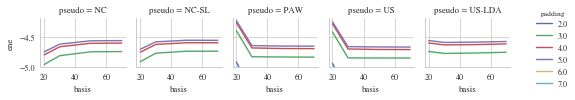

In [19]:
sns.FacetGrid(
    data=data['bz_tests'].loc['benzene', 'ene'] \
    .unstack().apply(lambda r: r['complex']-r['frag-1']-r['frag-2'], axis=1) \
    .unstack().apply(lambda r: r['vv10']-r['base'], axis=1) \
    .to_frame('ene').reset_index(),
    hue='padding',
    col='pseudo',
    margin_titles=True,
    size=1.5,
).map(sns.plt.plot, 'basis', 'ene').add_legend()
sns.plt.ylim(-5, -4.2)
savefig('bz-tests-padding-basis')

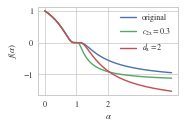

In [56]:
x = np.linspace(0, 4, 200)
fig = sns.plt.figure()
fig.set_size_inches(2.5, 2.5)
ax = fig.add_subplot(111)
lines = []
for c1x, c2x, dx in [(.667, .8, 1.24), (.667, .3, 1.24), (.667, .8, 2)]:
    def f(a):
        return exp(-c1x*a/(1-a))*heaviside(1-a, 0)-dx*exp(c2x/(1-a))*heaviside(a-1, 0)
    line, = ax.plot(x, f(x))
    lines.append(line)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$f(\alpha)$')
ax.set_xticks([0, 1, 2])
ax.set_yticks([-1, 0, 1])
ax.set_aspect(1, 'box')
ax.legend(lines, ['original', r'$c_\mathrm{2x}=0.3$', r'$d_\mathrm{x}=2$'])
savefig('scan-interp')